In [1]:
%matplotlib inline

import os
import statistics
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader

import constants
from dataset import OctRandomSliceDataset
from model2d import SimpleSliceNet
from training import evaluate, train_epoch

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
cubes_path = os.path.join(constants.PROCESSED_DATA_PATH, constants.CUBES_FOLDER)

train_dir = os.path.join(cubes_path, 'train')
val_dir = os.path.join(cubes_path, 'val')
test_dir = os.path.join(cubes_path, 'test')

def train_with_slice(slice_idx, num_epochs=10, verbose=True):
    print('==============')
    print(f'Training with slice index: {slice_idx}')
    
    train_dataset = OctRandomSliceDataset(train_dir, slice_min=slice_idx, slice_max=slice_idx)
    val_dataset = OctRandomSliceDataset(val_dir, slice_min=slice_idx, slice_max=slice_idx)
    test_dataset = OctRandomSliceDataset(test_dir, slice_min=slice_idx, slice_max=slice_idx)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8)

    net = SimpleSliceNet().to(device)

    if verbose: print('------ Evaluating ------')
    evaluate(net, val_loader, device, verbose)
    for epoch in range(1, num_epochs + 1):
        if verbose: print(f'====== Epoch {epoch} ======')
        train_loss = train_epoch(net, train_loader, device, verbose)

        if verbose: print('------ Evaluating ------')
        val_loss, auprc, auroc = evaluate(net, val_loader, device, verbose)
        
    return train_loss, val_loss, auprc, auroc

In [4]:
slice_idxs = [0, 25, 50, 75, 100, 125, 150, 175, 199]
train_losses = []
val_losses = []
auprcs = []
aurocs = []

for slice_idx in slice_idxs:
    train_loss, val_loss, auprc, auroc = train_with_slice(slice_idx)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    auprcs.append(auprc)
    aurocs.append(auroc)

Training with slice index: 0
Number of cubes: 964
Number of cubes: 142
Number of cubes: 207
------ Evaluating ------
Average precision score: 0.526728086202342
AUROC: 0.5531070081397658
Validation loss (approximate): 0.7259878830777274
Elapsed: 1.240938663482666
====== Epoch 1 ======
Train loss (approximate): 0.7621014758575061
Elapsed: 6.186114072799683
------ Evaluating ------
Average precision score: 0.5220948039742909
AUROC: 0.5269009330950962
Validation loss (approximate): 0.7172637681166331
Elapsed: 1.4952621459960938
====== Epoch 2 ======
Train loss (approximate): 0.7022108339573726
Elapsed: 6.303643226623535
------ Evaluating ------
Average precision score: 0.4920285262277639
AUROC: 0.50188604327973
Validation loss (approximate): 0.7834732913308673
Elapsed: 1.5435736179351807
====== Epoch 3 ======
Train loss (approximate): 0.6879429822125711
Elapsed: 6.298628807067871
------ Evaluating ------
Average precision score: 0.5174996957989786
AUROC: 0.5276950565812984
Validation loss 

Train loss (approximate): 0.5092946437518459
Elapsed: 6.381356477737427
------ Evaluating ------
Average precision score: 0.5515179725730837
AUROC: 0.6023426642842963
Validation loss (approximate): 0.8984074940284094
Elapsed: 1.536064624786377
====== Epoch 10 ======
Train loss (approximate): 0.43306134647328004
Elapsed: 6.344641447067261
------ Evaluating ------
Average precision score: 0.4929982298441461
AUROC: 0.510224339884852
Validation loss (approximate): 0.8822491218646368
Elapsed: 1.619508981704712
Training with slice index: 75
Number of cubes: 964
Number of cubes: 142
Number of cubes: 207
------ Evaluating ------
Average precision score: 0.46230712094876736
AUROC: 0.4310105221361922
Validation loss (approximate): 0.7183529304133521
Elapsed: 1.5438103675842285
====== Epoch 1 ======
Train loss (approximate): 0.8047382693645383
Elapsed: 6.368398189544678
------ Evaluating ------
Average precision score: 0.5754363070831792
AUROC: 0.6073059360730594
Validation loss (approximate): 0.

Train loss (approximate): 0.43157178052693357
Elapsed: 6.224076509475708
------ Evaluating ------
Average precision score: 0.5830360046019949
AUROC: 0.5364304149295216
Validation loss (approximate): 0.9354314787520303
Elapsed: 1.5287926197052002
====== Epoch 8 ======
Train loss (approximate): 0.38987212794378767
Elapsed: 6.3283092975616455
------ Evaluating ------
Average precision score: 0.6113006576017332
AUROC: 0.5715703791939646
Validation loss (approximate): 0.8608717338906394
Elapsed: 1.574819803237915
====== Epoch 9 ======
Train loss (approximate): 0.26187643033167546
Elapsed: 6.40552544593811
------ Evaluating ------
Average precision score: 0.617470321472538
AUROC: 0.5572761564423269
Validation loss (approximate): 0.9986320171091292
Elapsed: 1.6261093616485596
====== Epoch 10 ======
Train loss (approximate): 0.17343437000493372
Elapsed: 6.427632808685303
------ Evaluating ------
Average precision score: 0.5943037649039966
AUROC: 0.5247170935080405
Validation loss (approximate)

Train loss (approximate): 0.6320831342176958
Elapsed: 6.4875648021698
------ Evaluating ------
Average precision score: 0.4839233907665884
AUROC: 0.4689299186023427
Validation loss (approximate): 0.7794428368409475
Elapsed: 1.4787540435791016
====== Epoch 6 ======
Train loss (approximate): 0.6647564177670755
Elapsed: 6.280049800872803
------ Evaluating ------
Average precision score: 0.4384353625735484
AUROC: 0.41989279332936275
Validation loss (approximate): 0.8762913544972738
Elapsed: 1.4077942371368408
====== Epoch 7 ======
Train loss (approximate): 0.6237459626079591
Elapsed: 6.522912502288818
------ Evaluating ------
Average precision score: 0.4460115390864289
AUROC: 0.4355767321818543
Validation loss (approximate): 0.80972245004442
Elapsed: 1.497323751449585
====== Epoch 8 ======
Train loss (approximate): 0.5784331823676085
Elapsed: 6.338310241699219
------ Evaluating ------
Average precision score: 0.43916918987826525
AUROC: 0.40758387929323014
Validation loss (approximate): 0.8

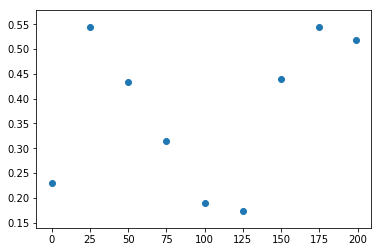

In [5]:
plt.scatter(slice_idxs, train_losses)

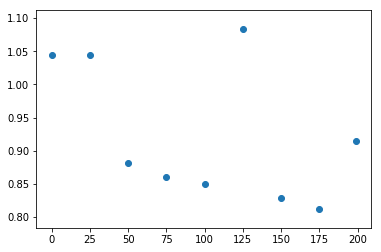

In [6]:
plt.scatter(slice_idxs, val_losses)

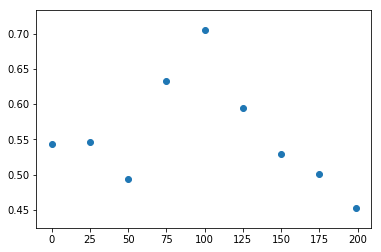

In [7]:
plt.scatter(slice_idxs, auprcs)

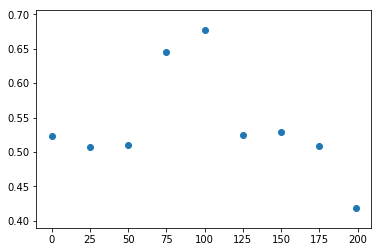

In [8]:
plt.scatter(slice_idxs, aurocs)